In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import mne
from mne.preprocessing import ICA, create_eog_epochs
from mne import io, combine_evoked
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.datasets import spm_face  # sample data
from glob import glob
import re
import yaml
from mne.preprocessing import ICA, read_ica
from mne.channels import make_standard_montage

print(__doc__)


Automatically created module for IPython interactive environment


Extracting parameters from /Volumes/lu32pog/Nan_ssvep/EEG data and analysis/Rawdata_exp1/QiuLiesefeld_SSVEP_0001.vhdr...
Setting channel info structure...
Reading 0 ... 6656639  =      0.000 ...  6656.639 secs...


/var/folders/l_/l_cqmr9n1f19wzndp8cbwl580000gn/T/ipykernel_3558/843904899.py:4: RuntimeWarning: Not setting positions of 3 eog channels found in montage:
['LO1', 'LO2', 'IO2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(raw_file,eog=('LO1', 'LO2', 'IO2'), misc='auto', scale=1.0, preload=True, verbose=None)


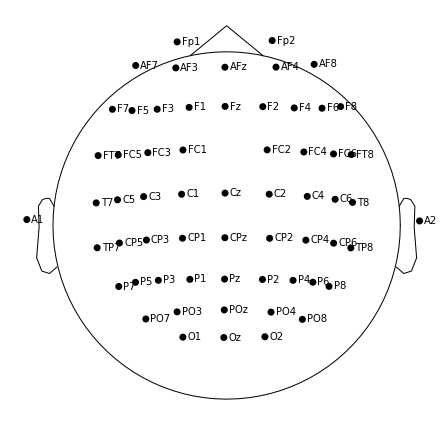

Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 45', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 52', 'Stimulus/S 62', 'Stimulus/S 63', 'Stimulus/S 65', 'Stimulus/S 66', 'Stimulus/S 79', 'Stimulus/S 80', 'Stimulus/S 82', 'Stimulus/S 83', 'Stimulus/S 93', 'Stimulus/S 96', 'Stimulus/S 97', 'Stimulus/S 98', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S150', 'Stimulus/S151', 'Stimulus/S152', 'Stimulus/S153', 'Stimulus/S200', 'Stimulus/S240', 'Stimulus/S241', 'Stimulus/S242', 'Stimulus/S244']
<RawBrainVision | QiuLiesefeld_SSVEP_0001.eeg, 64 x 6656640 (6656.6 s), ~3.17 GB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, LO1, FC5, FC1, C3, T7, A1, CP5, CP1, Pz, P3, ...
 chs: 61 EEG, 3 EOG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal,

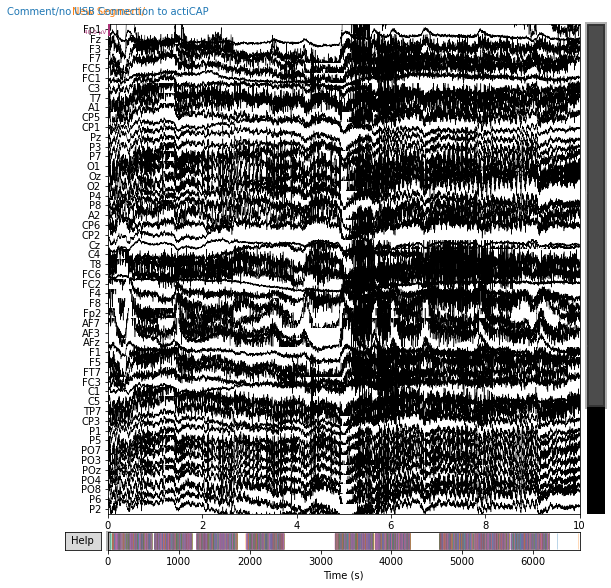

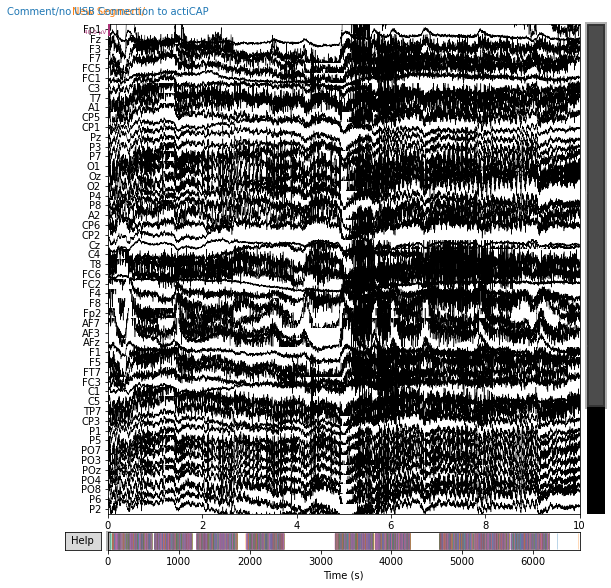

In [19]:
#load data
raw_file = "/Volumes/lu32pog/Nan_ssvep/EEG data and analysis/Rawdata_exp1/QiuLiesefeld_SSVEP_0001.vhdr"

raw = mne.io.read_raw_brainvision(raw_file,eog=('LO1', 'LO2', 'IO2'), misc='auto', scale=1.0, preload=True, verbose=None)
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.set_channel_types({'LO1': 'eog', 'LO2': 'eog', 'IO2': 'eog'})

fig = raw.plot_sensors(show_names=True)
events = mne.events_from_annotations(raw)
print(raw)
print(raw.info)
raw.plot(n_channels=50)

Load and filter data, set up epochs. 


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 45', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 52', 'Stimulus/S 62', 'Stimul

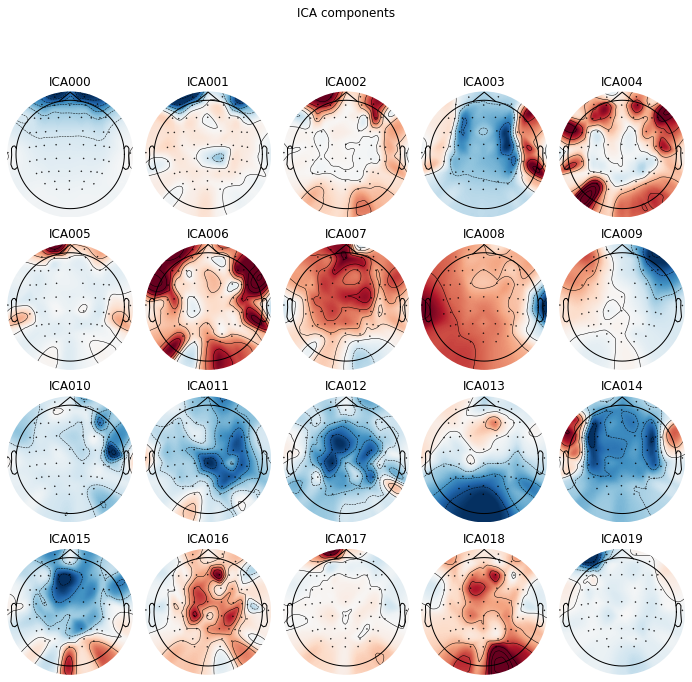

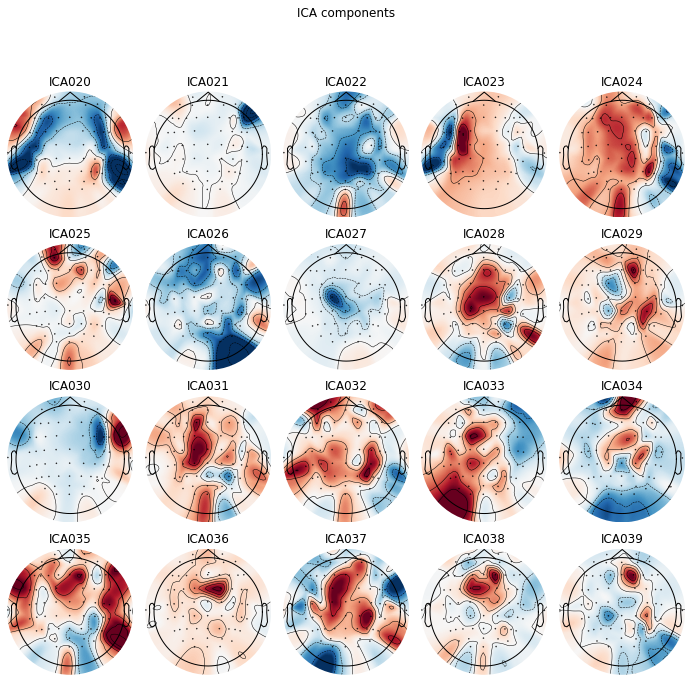

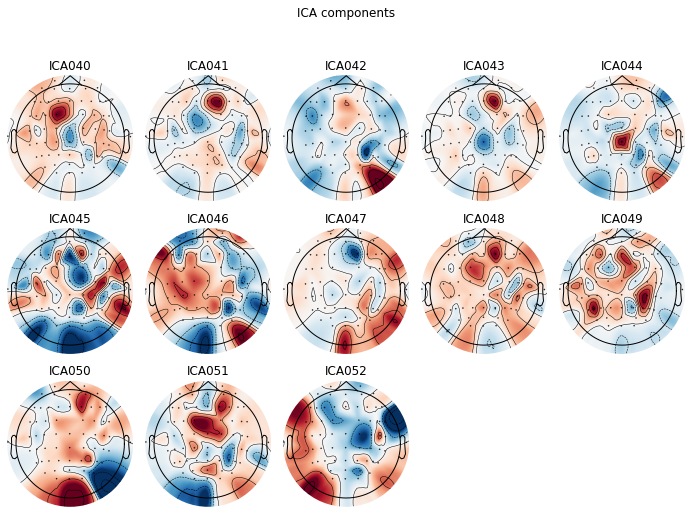

Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Opening ica-browser...


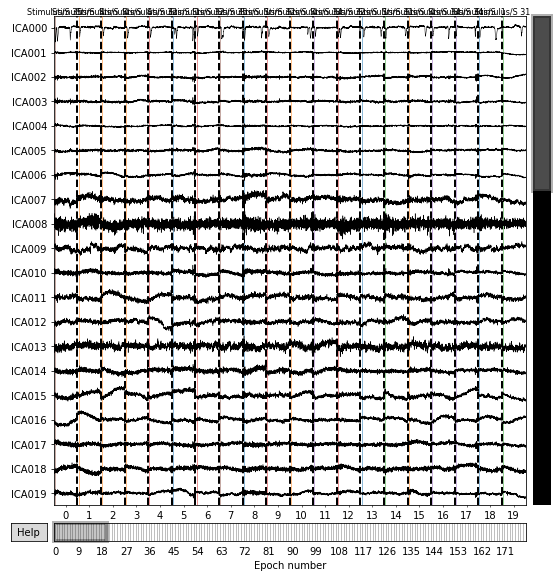

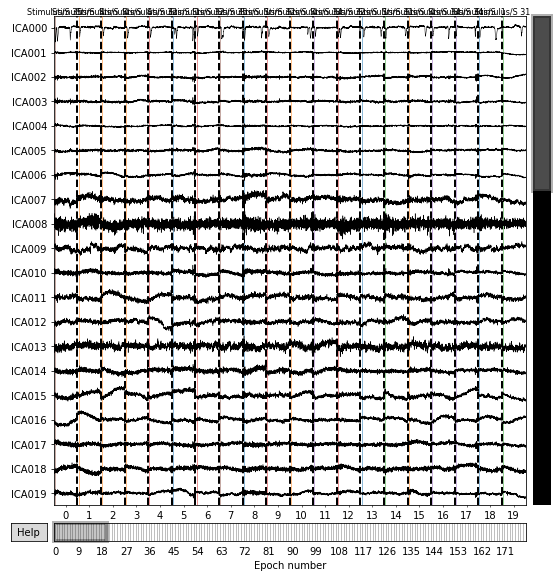

In [20]:
#resample
raw.resample(250, npad='auto')
#re-reference
raw.set_eeg_reference(['A1', 'A2'])
picks = mne.pick_types(raw.info, eeg=True, eog=False, stim=True, meg=True,exclude='bads')
raw.filter(0.1, 40, method='fir', fir_design='firwin')

##epochs
all_events, all_event_id = mne.events_from_annotations(raw)

tmin = -0.2
tmax = 4

metadata, events, event_id = mne.epochs.make_metadata(events=all_events, event_id=all_event_id, tmin=tmin, tmax=tmax, sfreq=raw.info['sfreq'] ,
                            row_events= ['Stimulus/S  4','Stimulus/S 31','Stimulus/S 34','Stimulus/S  1', 'Stimulus/S 32','Stimulus/S 35']) 
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax,metadata=metadata, baseline=None, preload=True)
epochs.metadata
print(epochs)
print(event_id)
epochs.metadata
reject = dict(mag=5e-12)

# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=0.999, max_iter=512, method='fastica')
ica.fit(epochs)
ica.plot_components()
ica.plot_sources(epochs)
# ica = mne.preprocessing.read_ica(ica)


# def run_ica(raw: mne.io.Raw, subject: str):
#     """ comments here."""
#     ica = ICA(n_components=0.999, max_iter=512, method='fastica')
#     ica.fit(raw)
#     ica.save('/Volumes/lu32pog/Nan_ssvep/EEG data and analysis/ica_exp2/{}-ssvep-ica.fif'.format(subject))
#     print(subject)

Using EOG channels: LO1, LO2, IO2
EOG channel index for this subject is: [ 4 26 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 1218 significant peaks
Number of EOG events detected: 1218
Not setting metadata
1218 matching events found
No baseline correction applied
Using data from preloaded Raw for 1218 events and 251 original time points ...
2 bad epochs dropped
Applying baseline correction (mode: mean)
No pro

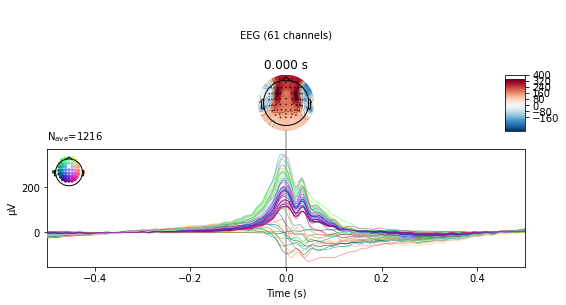

Using EOG channels: LO1, LO2, IO2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency:

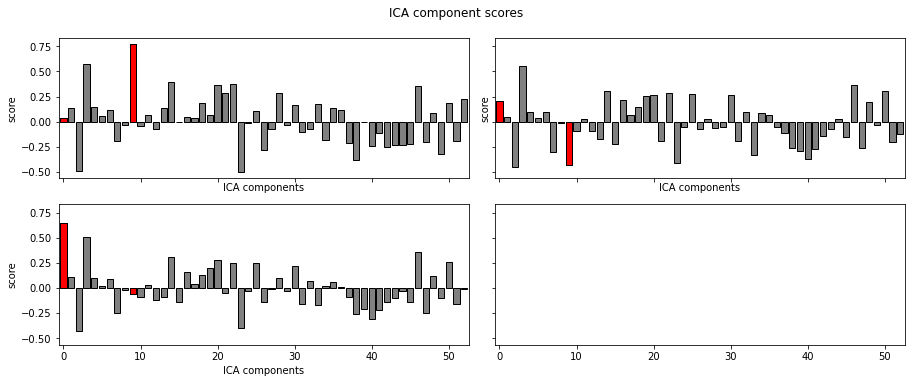

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3328 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
3328 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


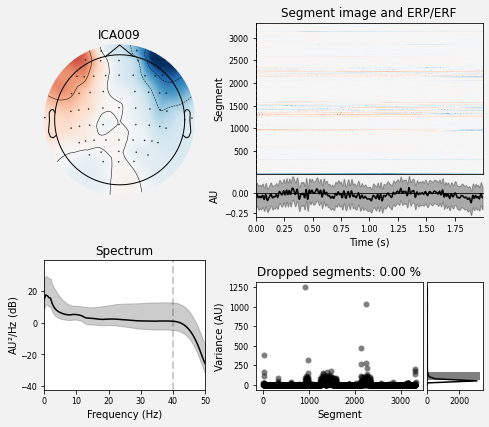

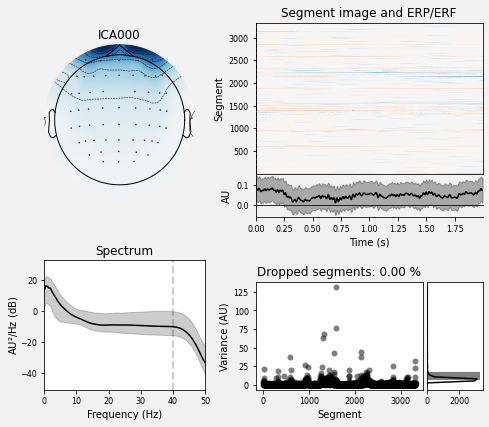

Creating RawArray with float64 data, n_channels=56, n_times=1664160
    Range : 0 ... 1664159 =      0.000 ...  6656.636 secs
Ready.
Opening ica-browser...


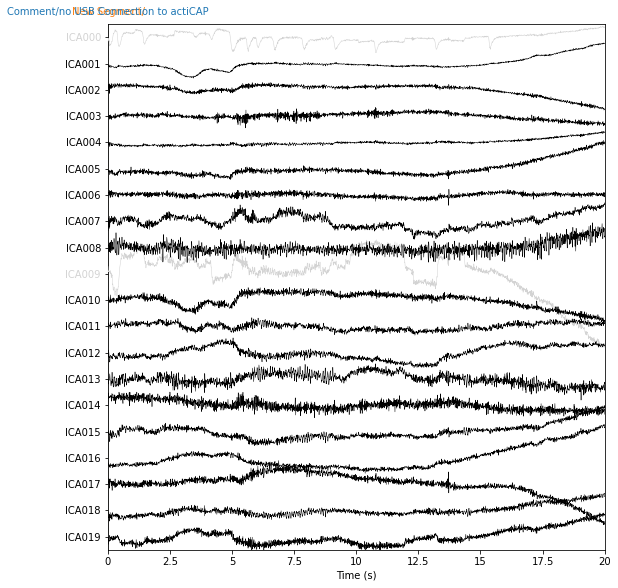

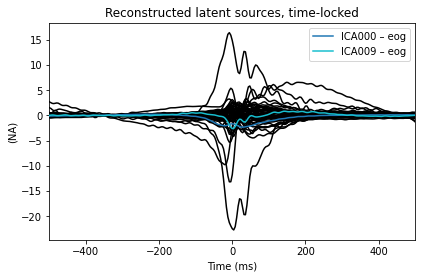

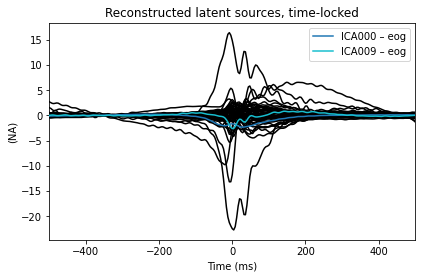

In [21]:
ica.exclude = []
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

In [22]:
# clean up memory before moving on
ica.save('/Volumes/lu32pog/Nan_ssvep/EEG data and analysis/ica_exp1_model/0001_ica_exp1_model.fif', overwrite=True)

Overwriting existing file.
Writing ICA solution to /Volumes/lu32pog/Nan_ssvep/EEG data and analysis/ica_exp1_model/0001_ica_exp1_model.fif...


/var/folders/l_/l_cqmr9n1f19wzndp8cbwl580000gn/T/ipykernel_3558/3153702350.py:2: RuntimeWarning: This filename (/Volumes/lu32pog/Nan_ssvep/EEG data and analysis/ica_exp1_model/0001_ica_exp1_model.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save('/Volumes/lu32pog/Nan_ssvep/EEG data and analysis/ica_exp1_model/0001_ica_exp1_model.fif', overwrite=True)


<ICA | epochs decomposition, method: fastica (fit in 83 iterations on 188129 samples), 53 ICA components explaining 99.9 % of variance (61 PCA components available), channel types: eeg, 2 sources marked for exclusion>

Applying ICA to Raw instance
    Transforming to ICA space (53 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Reading /Volumes/lu32pog/Nan_ssvep/EEG data and analysis/ica_exp1_model/0001_ica_exp1_model.fif ...
Now restoring ICA solution ...
Ready.


/var/folders/l_/l_cqmr9n1f19wzndp8cbwl580000gn/T/ipykernel_3558/1760685315.py:7: RuntimeWarning: This filename (/Volumes/lu32pog/Nan_ssvep/EEG data and analysis/ica_exp1_model/0001_ica_exp1_model.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = mne.preprocessing.read_ica(file_name)


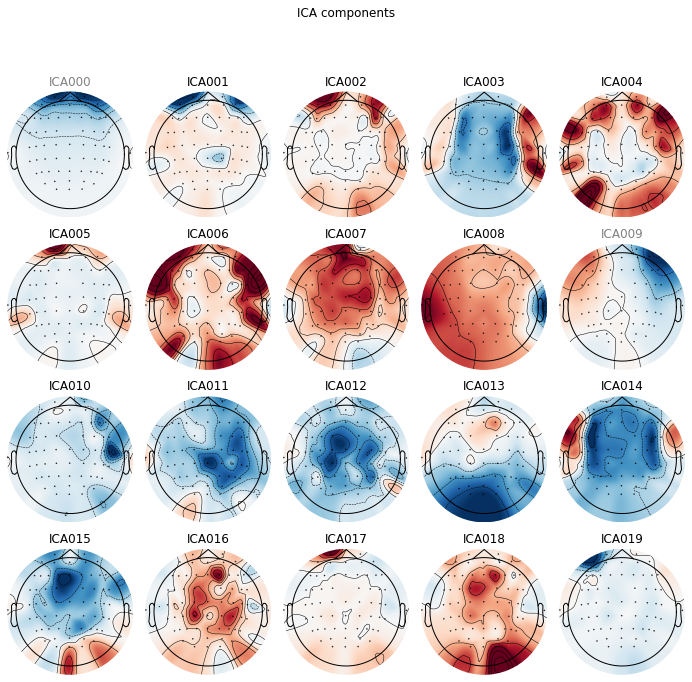

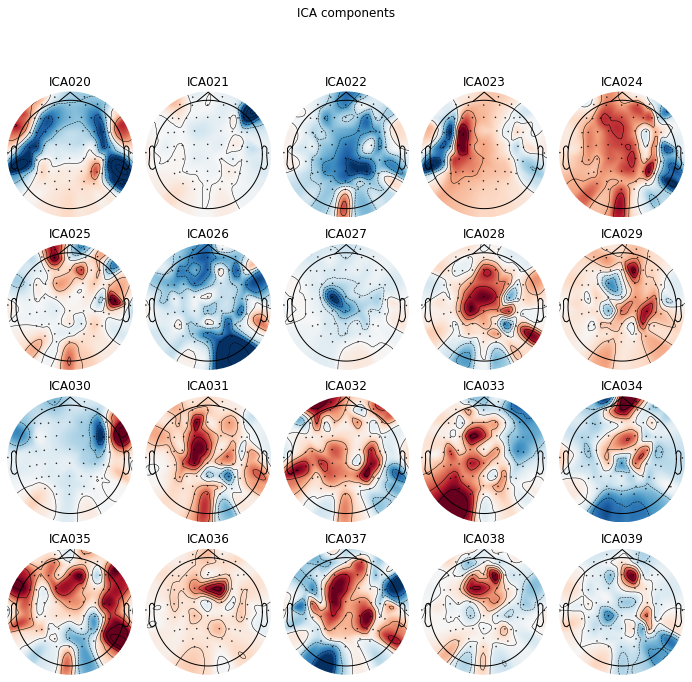

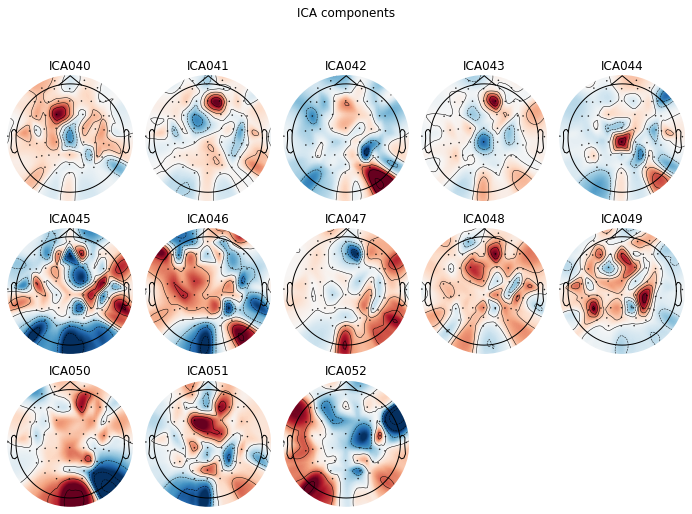

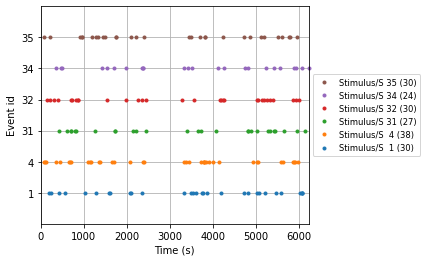

In [23]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)
# del raw, epochs  # free up memory

file_name = '/Volumes/lu32pog/Nan_ssvep/EEG data and analysis/ica_exp1_model/0001_ica_exp1_model.fif'
ica = mne.preprocessing.read_ica(file_name)
ica.plot_components()
fig = mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)


# reject_criteria = dict(eeg=100e-6, eog=200e-6)  # 100 µV, 200 µV
# epochs.drop_bad(reject=reject_criteria)

In [34]:
epochs = ica.apply(epochs, exclude=ica.exclude)
epochs.apply_baseline((None, 0))
epochs.save(file_name,overwrite=True)  # remember, the data has been cleaned of bad ICs


Applying ICA to Epochs instance
    Transforming to ICA space (53 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


/var/folders/l_/l_cqmr9n1f19wzndp8cbwl580000gn/T/ipykernel_3558/1337458897.py:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs = ica.apply(epochs, exclude=ica.exclude)


Applying baseline correction (mode: mean)
Overwriting existing file.


/var/folders/l_/l_cqmr9n1f19wzndp8cbwl580000gn/T/ipykernel_3558/1337458897.py:3: RuntimeWarning: This filename (/Volumes/lu32pog/Nan_ssvep/EEG data and analysis/ica_exp1_model/0001_ica_exp1_model.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(file_name,overwrite=True)  # remember, the data has been cleaned of bad ICs


In [29]:
# raw_fname = data_path + '/MEG/spm/SPM_CTF_MEG_example_faces%d_3D.ds'

# raw = io.read_raw_ctf(raw_fname % 1, preload=True)  # Take first run
# # Here to save memory and time we'll downsample heavily -- this is not
# # advised for real data as it can effectively jitter events!
# raw.resample(120., npad='auto')

# picks = mne.pick_types(raw.info, meg=True, exclude='bads')
# raw.filter(0.1, 30, method='fir', fir_design='firwin')

# events = mne.find_events(raw, stim_channel='UPPT001')

# # plot the events to get an idea of the paradigm
# mne.viz.plot_events(events, raw.info['sfreq'])

# event_ids = {"faces": 1, "scrambled": 2}

# tmin, tmax = -0.2, 0.6
# baseline = None  # no baseline as high-pass is applied
# reject = dict(mag=5e-12)

# epochs = mne.Epochs(raw, events, event_ids, tmin, tmax, picks=picks, baseline=baseline, preload=True, reject=reject)

# # Fit ICA, find and remove major artifacts
# ica = ICA(n_components=0.95, random_state=0).fit(raw, decim=1, reject=reject)

# # compute correlation scores, get bad indices sorted by score
# eog_epochs = create_eog_epochs(raw, ch_name='MRT31-2908', reject=reject)
# eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name='MRT31-2908')
# ica.plot_scores(eog_scores, eog_inds)  # see scores the selection is based on
# ica.plot_components(eog_inds)  # view topographic sensitivity of components
# ica.exclude += eog_inds[:1]  # we saw the 2nd ECG component looked too dipolar
# ica.plot_overlay(eog_epochs.average())  # inspect artifact removal
# ica.apply(epochs)  # clean data, default in place

# evoked = [epochs[k].average() for k in event_ids]

# contrast = combine_evoked(evoked, weights=[-1, 1])  # Faces - scrambled

# evoked.append(contrast)

# for e in evoked:
#     e.plot(ylim=dict(mag=[-400, 400]))

# plt.show()

# # estimate noise covarariance
# noise_cov = mne.compute_covariance(epochs, tmax=0, method='shrunk',rank=None)
# # 

In [26]:
# [k for k in range(10)]

Visualize fields on MEG helmet




In [ ]:
# # The transformation here was aligned using the dig-montage. It's included in
# # the spm_faces dataset and is named SPM_dig_montage.fif.
# trans_fname = data_path + ('/MEG/spm/SPM_CTF_MEG_example_faces1_3D_'
#                            'raw-trans.fif')

# maps = mne.make_field_map(evoked[0], trans_fname, subject='spm',
#                           subjects_dir=subjects_dir, n_jobs=1)

# evoked[0].plot_field(maps, time=0.170)


Compute forward model




In [28]:
# src = data_path + '/subjects/spm/bem/spm-oct-6-src.fif'
# bem = data_path + '/subjects/spm/bem/spm-5120-5120-5120-bem-sol.fif'
# forward = mne.make_forward_solution(contrast.info, trans_fname, src, bem)

In [27]:
# # Compute inverse solution
# snr = 3.0
# lambda2 = 1.0 / snr ** 2
# method = 'dSPM'

# inverse_operator = make_inverse_operator(contrast.info, forward, noise_cov,
#                                          loose=0.2, depth=0.8)

# # Compute inverse solution on contrast
# stc = apply_inverse(contrast, inverse_operator, lambda2, method, pick_ori=None)
# # stc.save('spm_%s_dSPM_inverse' % contrast.comment)

# # Plot contrast in 3D with PySurfer if available
# brain = stc.plot(hemi='both', subjects_dir=subjects_dir, initial_time=0.170,
#                  views=['ven'], clim={'kind': 'value', 'lims': [3., 6., 9.]})
# # brain.save_image('dSPM_map.png')